## NYC Restaurant Inspections 
### Author: Jack Robbins

Can we classify the letter grade of a restaurant inspection based on a variety of factors?

**Dataset Used**: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/about_data

In [77]:
# Important imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec

In [78]:
inspections = pd.read_csv("data/DOHMH_New_York_City_Restaurant_Inspection_Results_20241121.csv", low_memory=False)

In [79]:
inspections

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location Point1
0,50161678,CHIPOTLE MEXICAN GRILL #3056,Brooklyn,1746,ATLANTIC AVENUE,11213.0,6143187413,NaN,01/01/1900,NaN,...,NaN,40.677506,-73.932340,308.0,36.0,30900.0,3251126.0,3.013360e+09,BK61,NaN
1,50153724,ALICE'S TEA CUP CHAPTER II,Manhattan,156,EAST 64 STREET,10065.0,6464107205,NaN,01/01/1900,NaN,...,NaN,40.765200,-73.965568,108.0,4.0,12000.0,1042114.0,1.013980e+09,MN40,NaN
2,50154473,MONSIEUR BISTRO,Manhattan,853,LEXINGTON AVENUE,10065.0,3476076861,NaN,01/01/1900,NaN,...,NaN,40.765661,-73.965661,108.0,4.0,12000.0,1042380.0,1.013990e+09,MN40,NaN
3,50157000,HEA SOUTHEAST ASIAN STREET FOOD,Queens,3636,PRINCE ST,11354.0,9177431029,NaN,01/01/1900,NaN,...,NaN,40.761392,-73.832895,407.0,20.0,86900.0,4534920.0,4.049708e+09,QN22,NaN
4,50122996,MARTINY'S,Manhattan,121,EAST 17 STREET,10003.0,1646644923,NaN,01/01/1900,NaN,...,NaN,40.735975,-73.987620,105.0,2.0,5000.0,1082518.0,1.008730e+09,MN21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259052,41337363,NATIONAL BAKERY,Bronx,1617,WESTCHESTER AVENUE,10472.0,7188930660,Bakery Products/Desserts,10/21/2024,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,40.829441,-73.874825,209.0,17.0,6200.0,2025353.0,2.037770e+09,BX08,NaN
259053,50044368,CHOPSTICK,Brooklyn,884,REMSEN AVENUE,11236.0,7186293555,Chinese,01/28/2022,Violations were cited in the following area(s).,...,Cycle Inspection / Re-inspection,40.646378,-73.912834,318.0,42.0,96000.0,3397396.0,3.079200e+09,BK50,NaN
259054,50123737,WONDERFUL RESTAURANT,Bronx,518,EAST 240 STREET,10470.0,7183252800,Chinese,09/14/2022,Violations were cited in the following area(s).,...,Pre-permit (Operational) / Initial Inspection,40.901165,-73.861981,212.0,11.0,45102.0,2019826.0,2.033980e+09,BX62,NaN
259055,41086368,LUZ DE AMERICA RESTAURANT,Queens,10430,ROOSEVELT AVENUE,11368.0,7186512060,Latin American,01/19/2023,Violations were cited in the following area(s).,...,Cycle Inspection / Re-inspection,40.750175,-73.860548,404.0,21.0,40300.0,4048773.0,4.019840e+09,QN26,NaN


In [80]:
# Let's get an idea of the shape of the graph
inspections.shape

(259057, 27)

In [81]:
null_values = inspections.isnull().sum()
print(null_values)

CAMIS                         0
DBA                         966
BORO                          0
BUILDING                    372
STREET                        3
ZIPCODE                    2662
PHONE                         3
CUISINE DESCRIPTION        2846
INSPECTION DATE               0
ACTION                     2846
VIOLATION CODE             4444
VIOLATION DESCRIPTION      4444
CRITICAL FLAG                 0
SCORE                     12765
GRADE                    134200
GRADE DATE               143494
RECORD DATE                   0
INSPECTION TYPE            2846
Latitude                    353
Longitude                   353
Community Board            3297
Council District           3287
Census Tract               3287
BIN                        4610
BBL                         638
NTA                        3297
Location Point1          259057
dtype: int64


### Let's drop unneeded columns

The columns BIN, BBL, NTA, and location point 1 have no official description on the data page and are therefore useless to us. We'll get rid of them. We'll also remove the CAMIS, GRADE DATE, PHONE, DBA, VIOLATION DESCRIPTION, latitude and longitude columns. These columns are documented but they are not useful to us, so it makes sense to remove.

In [82]:
inspections.drop(['Location Point1', 'NTA', 'BBL', 'BIN', 'CAMIS', 'GRADE DATE', 'PHONE', 'Latitude', 'Longitude', 'DBA',\
                  'BUILDING', 'STREET', 'VIOLATION DESCRIPTION', 'RECORD DATE'], axis = 1, inplace=True)
null_values = inspections.isnull().sum()
print(null_values)

BORO                        0
ZIPCODE                  2662
CUISINE DESCRIPTION      2846
INSPECTION DATE             0
ACTION                   2846
VIOLATION CODE           4444
CRITICAL FLAG               0
SCORE                   12765
GRADE                  134200
INSPECTION TYPE          2846
Community Board          3297
Council District         3287
Census Tract             3287
dtype: int64


### Let's analyze these findings 
As we can see above there are a lot of null values for the grade and grade date. The grade date would be very interesting for us to look at, so it's tempting to try and either fill those nulls or drop those columns

In [83]:
inspections['SCORE'].describe()

count    246292.000000
mean         24.091895
std          18.210236
min           0.000000
25%          12.000000
50%          20.000000
75%          32.000000
max         168.000000
Name: SCORE, dtype: float64

In [84]:
# Let's remove all rows that have a null score
inspections.dropna(subset=['SCORE'], inplace=True)

### Filling in missing grades

From the [NYC department of health](https://www.nyc.gov/assets/doh/downloads/pdf/about/healthcode/health-code-chapter23.pdf) website, the letter grade based off of score is as follows
* Grade A: 0-13 points scored
* Grade B: 14-27 points scored
* Grade C: >=28 points scored

We can use this to figure out what the grades are now

In [85]:
def grade_from_score(score):
    int_score = int(score)
    if int_score < 14:
        return 'A'
    elif int_score < 28:
        return 'B'
    else:
        return 'C'
    
# Fill in the grade based on score
inspections['GRADE'] = inspections['SCORE'].apply(grade_from_score)
inspections

,BORO,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,CRITICAL FLAG,SCORE,GRADE,INSPECTION TYPE,Community Board,Council District,Census Tract
26,Queens,11368.0,Pizza,05/02/2022,Violations were cited in the following area(s).,02B,Critical,12.0,A,Cycle Inspection / Initial Inspection,404.0,21.0,44302.0
38,Manhattan,10013.0,Chinese,11/12/2024,Violations were cited in the following area(s).,09B,Not Critical,27.0,B,Cycle Inspection / Re-inspection,103.0,1.0,2900.0
44,Brooklyn,11211.0,Jewish/Kosher,03/10/2022,Violations were cited in the following area(s).,02B,Critical,53.0,C,Cycle Inspection / Initial Inspection,301.0,33.0,52500.0
46,Queens,11355.0,Korean,03/22/2023,Violations were cited in the following area(s).,04M,Critical,75.0,C,Cycle Inspection / Initial Inspection,407.0,20.0,116700.0
48,Manhattan,10036.0,Seafood,09/09/2024,No violations were recorded at the time of thi...,NaN,Not Applicable,0.0,A,Inter-Agency Task Force / Initial Inspection,105.0,4.0,11900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259052,Bronx,10472.0,Bakery Products/Desserts,10/21/2024,Violations were cited in the following area(s).,04L,Critical,21.0,B,Cycle Inspection / Initial Inspection,209.0,17.0,6200.0
259053,Brooklyn,11236.0,Chinese,01/28/2022,Violations were cited in the following area(s).,10F,Not Critical,9.0,A,Cycle Inspection / Re-inspection,318.0,42.0,96000.0
259054,Bronx,10470.0,Chinese,09/14/2022,Violations were cited in the following area(s).,08A,Not Critical,53.0,C,Pre-permit (Operational) / Initial Inspection,212.0,11.0,45102.0
259055,Queens,11368.0,Latin American,01/19/2023,Violations were cited in the following area(s).,10F,Not Critical,23.0,B,Cycle Inspection / Re-inspection,404.0,21.0,40300.0


In [86]:
null_values = inspections.isnull().sum()
print(null_values)

BORO                      0
ZIPCODE                2508
CUISINE DESCRIPTION       0
INSPECTION DATE           0
ACTION                    0
VIOLATION CODE         1017
CRITICAL FLAG             0
SCORE                     0
GRADE                     0
INSPECTION TYPE           0
Community Board        3081
Council District       3071
Census Tract           3071
dtype: int64


In [87]:
inspections.shape

(246292, 13)

## Handling the rest of the nulls

At this point, we have a small number of rows that still contain null values. This is an acceptable loss for us, so we will go through and drop them.

In [88]:
inspections.dropna(how='any', inplace=True)

In [89]:
# Let's see how we did
null_values = inspections.isnull().sum()
print(null_values)

BORO                   0
ZIPCODE                0
CUISINE DESCRIPTION    0
INSPECTION DATE        0
ACTION                 0
VIOLATION CODE         0
CRITICAL FLAG          0
SCORE                  0
GRADE                  0
INSPECTION TYPE        0
Community Board        0
Council District       0
Census Tract           0
dtype: int64


In [90]:
inspections.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242242 entries, 26 to 259056
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   BORO                 242242 non-null  object 
 1   ZIPCODE              242242 non-null  float64
 2   CUISINE DESCRIPTION  242242 non-null  object 
 3   INSPECTION DATE      242242 non-null  object 
 4   ACTION               242242 non-null  object 
 5   VIOLATION CODE       242242 non-null  object 
 6   CRITICAL FLAG        242242 non-null  object 
 7   SCORE                242242 non-null  float64
 8   GRADE                242242 non-null  object 
 9   INSPECTION TYPE      242242 non-null  object 
 10  Community Board      242242 non-null  float64
 11  Council District     242242 non-null  float64
 12  Census Tract         242242 non-null  float64
dtypes: float64(5), object(8)
memory usage: 25.9+ MB


## Remaining cleanup

Even though we no longer have any null values in our dataframe, that does not mean that there isn't still junk in there. Let's look at each feature and see what still needs to be cleaned up

In [91]:
# Boro looks good to me
inspections['BORO'].unique()

array(['Queens', 'Manhattan', 'Brooklyn', 'Bronx', 'Staten Island'],
      dtype=object)

In [92]:
# Let's deal with zipcodes. Notice how zipcodes are floats, when in reality they should be ints. Let's fix this real quick
inspections['ZIPCODE'] = inspections['ZIPCODE'].apply(lambda x: int(x))

In [93]:
# Let's take a look at cuisine description
inspections['CUISINE DESCRIPTION'].unique()

array(['Pizza', 'Chinese', 'Jewish/Kosher', 'Korean', 'Italian',
       'Latin American', 'American', 'Greek', 'Caribbean',
       'Bakery Products/Desserts', 'Chinese/Japanese', 'Donuts',
       'Mexican', 'Japanese', 'Tex-Mex', 'Hawaiian', 'Spanish',
       'Asian/Asian Fusion', 'Tapas', 'Thai', 'Southeast Asian',
       'Chicken', 'Creole', 'Vegan', 'Middle Eastern', 'Bagels/Pretzels',
       'Indian', 'Hamburgers', 'Filipino', 'Peruvian', 'Seafood', 'Other',
       'Coffee/Tea', 'Fusion', 'Barbecue', 'Irish', 'Salads', 'Brazilian',
       'Frozen Desserts', 'African', 'Mediterranean', 'Sandwiches',
       'French', 'Eastern European', 'Polish', 'Continental',
       'Sandwiches/Salads/Mixed Buffet', 'Bangladeshi',
       'Juice, Smoothies, Fruit Salads', 'Bottled Beverages',
       'Australian', 'Russian', 'Egyptian', 'Moroccan', 'Turkish',
       'Vegetarian', 'Armenian', 'Pakistani', 'Steakhouse',
       'Fruits/Vegetables', 'Pancakes/Waffles', 'Chinese/Cuban',
       'Soul Food'

In [94]:
# How many of these do we have?
inspections[inspections['CUISINE DESCRIPTION'] == 'Not Listed/Not Applicable']

,BORO,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,CRITICAL FLAG,SCORE,GRADE,INSPECTION TYPE,Community Board,Council District,Census Tract
2749,Brooklyn,11201,Not Listed/Not Applicable,04/25/2022,Violations were cited in the following area(s).,04N,Critical,0.0,A,Pre-permit (Operational) / Re-inspection,302.0,33.0,1500.0
7651,Manhattan,10012,Not Listed/Not Applicable,04/12/2023,Establishment Closed by DOHMH. Violations were...,10F,Not Critical,25.0,B,Cycle Inspection / Initial Inspection,102.0,2.0,6500.0
8800,Brooklyn,11206,Not Listed/Not Applicable,09/08/2023,Violations were cited in the following area(s).,10G,Not Critical,12.0,A,Pre-permit (Operational) / Re-inspection,301.0,34.0,48500.0
11700,Brooklyn,11249,Not Listed/Not Applicable,01/11/2024,Violations were cited in the following area(s).,10F,Not Critical,4.0,A,Cycle Inspection / Initial Inspection,301.0,34.0,55300.0
11992,Queens,11101,Not Listed/Not Applicable,12/02/2021,Violations were cited in the following area(s).,04A,Critical,12.0,A,Pre-permit (Operational) / Initial Inspection,402.0,26.0,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
242063,Manhattan,10012,Not Listed/Not Applicable,03/22/2022,Violations were cited in the following area(s).,10B,Not Critical,13.0,A,Cycle Inspection / Initial Inspection,102.0,2.0,6500.0
243303,Manhattan,10002,Not Listed/Not Applicable,04/02/2024,Violations were cited in the following area(s).,04O,Critical,20.0,B,Cycle Inspection / Initial Inspection,103.0,1.0,1800.0
245915,Manhattan,10002,Not Listed/Not Applicable,04/02/2024,Violations were cited in the following area(s).,06E,Critical,20.0,B,Cycle Inspection / Initial Inspection,103.0,1.0,1800.0
247714,Brooklyn,11201,Not Listed/Not Applicable,02/22/2022,Violations were cited in the following area(s).,04N,Critical,0.0,A,Pre-permit (Operational) / Initial Inspection,302.0,33.0,1500.0


In [95]:
# We'll get rid of these rows because they're likely junk
indices_to_drop = inspections[inspections['CUISINE DESCRIPTION'] == 'Not Listed/Not Applicable'].index
inspections.drop(index=indices_to_drop, inplace=True)

In [96]:
# All fixed now...
inspections['CUISINE DESCRIPTION'].unique()

array(['Pizza', 'Chinese', 'Jewish/Kosher', 'Korean', 'Italian',
       'Latin American', 'American', 'Greek', 'Caribbean',
       'Bakery Products/Desserts', 'Chinese/Japanese', 'Donuts',
       'Mexican', 'Japanese', 'Tex-Mex', 'Hawaiian', 'Spanish',
       'Asian/Asian Fusion', 'Tapas', 'Thai', 'Southeast Asian',
       'Chicken', 'Creole', 'Vegan', 'Middle Eastern', 'Bagels/Pretzels',
       'Indian', 'Hamburgers', 'Filipino', 'Peruvian', 'Seafood', 'Other',
       'Coffee/Tea', 'Fusion', 'Barbecue', 'Irish', 'Salads', 'Brazilian',
       'Frozen Desserts', 'African', 'Mediterranean', 'Sandwiches',
       'French', 'Eastern European', 'Polish', 'Continental',
       'Sandwiches/Salads/Mixed Buffet', 'Bangladeshi',
       'Juice, Smoothies, Fruit Salads', 'Bottled Beverages',
       'Australian', 'Russian', 'Egyptian', 'Moroccan', 'Turkish',
       'Vegetarian', 'Armenian', 'Pakistani', 'Steakhouse',
       'Fruits/Vegetables', 'Pancakes/Waffles', 'Chinese/Cuban',
       'Soul Food'

### Dealing with Inspection Date
Inspection date here by itself is fine, but I suspect that we won't be able to get trends out of a day-by-day date. Instead, we'll extract the months here and replace the entire column with a months column

In [97]:
# A helper function for us
def date_to_months(date):
    # Split along a /
    split = date.split("/")
    
    return int(split[0])

inspections['INSPECTION MONTH'] = inspections['INSPECTION DATE'].apply(date_to_months)
inspections.drop('INSPECTION DATE', axis=1, inplace=True)
inspections

,BORO,ZIPCODE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,CRITICAL FLAG,SCORE,GRADE,INSPECTION TYPE,Community Board,Council District,Census Tract,INSPECTION MONTH
26,Queens,11368,Pizza,Violations were cited in the following area(s).,02B,Critical,12.0,A,Cycle Inspection / Initial Inspection,404.0,21.0,44302.0,5
38,Manhattan,10013,Chinese,Violations were cited in the following area(s).,09B,Not Critical,27.0,B,Cycle Inspection / Re-inspection,103.0,1.0,2900.0,11
44,Brooklyn,11211,Jewish/Kosher,Violations were cited in the following area(s).,02B,Critical,53.0,C,Cycle Inspection / Initial Inspection,301.0,33.0,52500.0,3
46,Queens,11355,Korean,Violations were cited in the following area(s).,04M,Critical,75.0,C,Cycle Inspection / Initial Inspection,407.0,20.0,116700.0,3
49,Brooklyn,11249,Italian,Violations were cited in the following area(s).,04L,Critical,26.0,B,Cycle Inspection / Initial Inspection,301.0,33.0,54900.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259052,Bronx,10472,Bakery Products/Desserts,Violations were cited in the following area(s).,04L,Critical,21.0,B,Cycle Inspection / Initial Inspection,209.0,17.0,6200.0,10
259053,Brooklyn,11236,Chinese,Violations were cited in the following area(s).,10F,Not Critical,9.0,A,Cycle Inspection / Re-inspection,318.0,42.0,96000.0,1
259054,Bronx,10470,Chinese,Violations were cited in the following area(s).,08A,Not Critical,53.0,C,Pre-permit (Operational) / Initial Inspection,212.0,11.0,45102.0,9
259055,Queens,11368,Latin American,Violations were cited in the following area(s).,10F,Not Critical,23.0,B,Cycle Inspection / Re-inspection,404.0,21.0,40300.0,1


In [98]:
# Let's look at action. This looks fine to me, we'll encode it later
inspections['ACTION'].unique()

array(['Violations were cited in the following area(s).',
       'Establishment re-opened by DOHMH.',
       'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.',
       'No violations were recorded at the time of this inspection.'],
      dtype=object)

In [99]:
# Let's now look at violation code. These also look fine to me, and we'll encode them later
inspections['VIOLATION CODE'].unique()

array(['02B', '09B', '04M', '04L', '06F', '10C', '10J', '03I', '10H',
       '09E', '09C', '04K', '02A', '08A', '04A', '10F', '10B', '06D',
       '06B', '04N', '06C', '10E', '06A', '02G', '04J', '08C', '06E',
       '02H', '05E', '28-06', '05H', '04H', '10I', '05D', '04C', '05C',
       '03A', '10G', '10A', '08B', '09A', '04O', '02I', '28-05', '10D',
       '04P', '03B', '06G', '05A', '04F', '03C', '02C', '05F', '03E',
       '04E', '04D', '05B', '02F', '02D', '07A', '03F', '09D', '28-07',
       '04B', '18-11', '22F', '06H', '03G', '06I', '03D', '22G', '04I'],
      dtype=object)

In [100]:
# Let's have a look at critical_flag. Also looks completely fine to me
inspections['CRITICAL FLAG'].unique()

array(['Critical', 'Not Critical'], dtype=object)

In [101]:
# Let's just encode it right now
inspections['CRITICAL FLAG'] = inspections['CRITICAL FLAG'].apply(lambda x: 1 if x == 'Critical' else 0)
inspections

,BORO,ZIPCODE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,CRITICAL FLAG,SCORE,GRADE,INSPECTION TYPE,Community Board,Council District,Census Tract,INSPECTION MONTH
26,Queens,11368,Pizza,Violations were cited in the following area(s).,02B,1,12.0,A,Cycle Inspection / Initial Inspection,404.0,21.0,44302.0,5
38,Manhattan,10013,Chinese,Violations were cited in the following area(s).,09B,0,27.0,B,Cycle Inspection / Re-inspection,103.0,1.0,2900.0,11
44,Brooklyn,11211,Jewish/Kosher,Violations were cited in the following area(s).,02B,1,53.0,C,Cycle Inspection / Initial Inspection,301.0,33.0,52500.0,3
46,Queens,11355,Korean,Violations were cited in the following area(s).,04M,1,75.0,C,Cycle Inspection / Initial Inspection,407.0,20.0,116700.0,3
49,Brooklyn,11249,Italian,Violations were cited in the following area(s).,04L,1,26.0,B,Cycle Inspection / Initial Inspection,301.0,33.0,54900.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259052,Bronx,10472,Bakery Products/Desserts,Violations were cited in the following area(s).,04L,1,21.0,B,Cycle Inspection / Initial Inspection,209.0,17.0,6200.0,10
259053,Brooklyn,11236,Chinese,Violations were cited in the following area(s).,10F,0,9.0,A,Cycle Inspection / Re-inspection,318.0,42.0,96000.0,1
259054,Bronx,10470,Chinese,Violations were cited in the following area(s).,08A,0,53.0,C,Pre-permit (Operational) / Initial Inspection,212.0,11.0,45102.0,9
259055,Queens,11368,Latin American,Violations were cited in the following area(s).,10F,0,23.0,B,Cycle Inspection / Re-inspection,404.0,21.0,40300.0,1


In [102]:
# Let's now check in on score. It should be numerical, but instead it's an object. We'll fix this real quick
inspections['SCORE'] = inspections['SCORE'].apply(lambda x: int(x))

In [103]:
# Almost there, let's check the grade now. This looks good to me
inspections['GRADE'].unique()

array(['A', 'B', 'C'], dtype=object)

In [104]:
# Let's check inspection type. This looks good to me as well, we'll encode it later on
inspections['INSPECTION TYPE'].unique()

array(['Cycle Inspection / Initial Inspection',
       'Cycle Inspection / Re-inspection',
       'Pre-permit (Operational) / Re-inspection',
       'Pre-permit (Operational) / Initial Inspection',
       'Pre-permit (Operational) / Reopening Inspection',
       'Pre-permit (Operational) / Compliance Inspection',
       'Cycle Inspection / Second Compliance Inspection',
       'Cycle Inspection / Reopening Inspection',
       'Pre-permit (Non-operational) / Initial Inspection',
       'Cycle Inspection / Compliance Inspection',
       'Pre-permit (Operational) / Second Compliance Inspection',
       'Inter-Agency Task Force / Initial Inspection',
       'Pre-permit (Non-operational) / Compliance Inspection',
       'Pre-permit (Non-operational) / Re-inspection',
       'Pre-permit (Non-operational) / Second Compliance Inspection'],
      dtype=object)

In [105]:
# The community board, Council district and census tract are all floats, and should be converted to ints. We'll do that right now
inspections['Council District'] = inspections['Council District'].apply(lambda x: int(x))
inspections['Community Board'] = inspections['Community Board'].apply(lambda x: int(x))
inspections['Census Tract'] = inspections['Census Tract'].apply(lambda x: int(x))

In [106]:
inspections

,BORO,ZIPCODE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,CRITICAL FLAG,SCORE,GRADE,INSPECTION TYPE,Community Board,Council District,Census Tract,INSPECTION MONTH
26,Queens,11368,Pizza,Violations were cited in the following area(s).,02B,1,12,A,Cycle Inspection / Initial Inspection,404,21,44302,5
38,Manhattan,10013,Chinese,Violations were cited in the following area(s).,09B,0,27,B,Cycle Inspection / Re-inspection,103,1,2900,11
44,Brooklyn,11211,Jewish/Kosher,Violations were cited in the following area(s).,02B,1,53,C,Cycle Inspection / Initial Inspection,301,33,52500,3
46,Queens,11355,Korean,Violations were cited in the following area(s).,04M,1,75,C,Cycle Inspection / Initial Inspection,407,20,116700,3
49,Brooklyn,11249,Italian,Violations were cited in the following area(s).,04L,1,26,B,Cycle Inspection / Initial Inspection,301,33,54900,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259052,Bronx,10472,Bakery Products/Desserts,Violations were cited in the following area(s).,04L,1,21,B,Cycle Inspection / Initial Inspection,209,17,6200,10
259053,Brooklyn,11236,Chinese,Violations were cited in the following area(s).,10F,0,9,A,Cycle Inspection / Re-inspection,318,42,96000,1
259054,Bronx,10470,Chinese,Violations were cited in the following area(s).,08A,0,53,C,Pre-permit (Operational) / Initial Inspection,212,11,45102,9
259055,Queens,11368,Latin American,Violations were cited in the following area(s).,10F,0,23,B,Cycle Inspection / Re-inspection,404,21,40300,1


inspections.info()

## Data cleaning finished -> Time to Encode

Now that the data is all cleaned, we can encode all of the categorical columns in preparation for exploratory data analysis/model training

In [107]:
# We'll make a separate label encoder for each here just in case we want to make a prediction and encode some data later
boro_le = preprocessing.LabelEncoder()
desc_le = preprocessing.LabelEncoder()
action_le = preprocessing.LabelEncoder()
code_le = preprocessing.LabelEncoder()
grade_le = preprocessing.LabelEncoder()
type_le = preprocessing.LabelEncoder()

inspections['BORO'] = boro_le.fit_transform(inspections['BORO'])
inspections['CUISINE DESCRIPTION'] = desc_le.fit_transform(inspections['CUISINE DESCRIPTION'])
inspections['ACTION'] = action_le.fit_transform(inspections['ACTION'])
inspections['VIOLATION CODE'] = code_le.fit_transform(inspections['VIOLATION CODE'])
inspections['GRADE'] = grade_le.fit_transform(inspections['GRADE'])
inspections['INSPECTION TYPE'] = type_le.fit_transform(inspections['INSPECTION TYPE'])

In [108]:
# The final cleaned and encoded dataset
inspections

,BORO,ZIPCODE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,CRITICAL FLAG,SCORE,GRADE,INSPECTION TYPE,Community Board,Council District,Census Tract,INSPECTION MONTH
26,3,11368,66,3,1,1,12,0,1,404,21,44302,5
38,2,10013,19,3,52,0,27,1,2,103,1,2900,11
44,1,11211,50,3,1,1,53,2,1,301,33,52500,3
46,3,11355,52,3,27,1,75,2,1,407,20,116700,3
49,1,11249,48,3,26,1,26,1,1,301,33,54900,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259052,0,10472,7,3,26,1,21,1,1,209,17,6200,10
259053,1,11236,19,3,61,0,9,0,2,318,42,96000,1
259054,0,10470,19,3,48,0,53,2,11,212,11,45102,9
259055,3,11368,53,3,61,0,23,1,2,404,21,40300,1


## Exploratory Data Analysis

Let's now look at how some of these factors may correlate or relate in some way to the letter grade of a restaurant.

### But first, let's see if there are any class imbalances that we need to deal with

[Text(0.5, 1.0, 'GRADE FREQUENCY')]

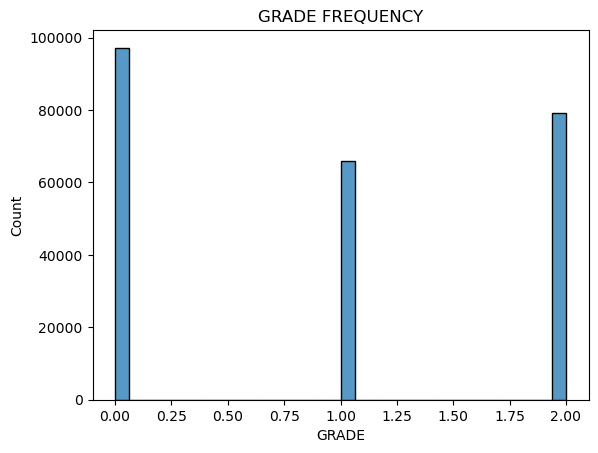

In [109]:
sns.histplot(data=inspections, x="GRADE").set(title="GRADE FREQUENCY")

As we can see here, grade frequency is not imbalanced in any major way. Let's now use a pairplot to get a global view of the whole dataset.

### Pairplot

In [ ]:
sns.pairplot(inspections)

Taking a look at the above pairplot, there are some features that show promise like Cuisine Description, Action, Violation Code, Inspection Type and Census Tract. Let's look at some of the features individually to see if we can ascertain anything.

### Cuisine Description
Let's see if a restaurant's locality in one of the 5 boros seems to have any effect on the score